In [10]:
import os
import pandas as pd
import numpy as np
from scipy import interpolate
from itertools import chain
from multiprocessing import Pool
import re
import h5py
import time
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from SCOPE_func import *
from fun_nearealtime_RTM import *
from main_GOES_realtime import *


In [11]:
data_dir = './GOES_data/'
sky="day"
if sky == "night":
    timeofday = "night"
else:
    timeofday = "day"
Sat_dir = Sat_preprocess(data_dir, sat='GOES16')
sat = pd.read_hdf(
    os.path.join(data_dir+Sat_dir, "GOES_day_BON_radiance_satellite_{}.h5".format(sky)),
    'df'
)
channels = ['C{:02d}'.format(c) for c in range(1, 6 + 1)]
try:
    sat_ref = sat[channels]
except KeyError:
    sat_ref = sat['Radiance']

Filtered DataFrame saved to ./GOES_data/GOES16_site_sat_data/GOES_day_BON_radiance_satellite_day.h5


### mode test

In [12]:
Sun_Zen=32
local_zen=48
rela_azi=20
COD_guess=10
T_a=299
RH=61
channels=['C01', 'C02', 'C03', 'C04', 'C05', 'C06']

In [13]:
bandmode = 'GOES' # GOES, full
COD_guess = 10
N_bundles = 10000
Rc_rtm = nearealtime_RTM(Sun_Zen, local_zen, rela_azi, COD_guess, T_a, RH, channels,
                          file_dir=data_dir,bandmode=bandmode,N_bundles=N_bundles)
Rc_rtm

,C01,C02,C03,C04,C05,C06
0,8.04403,14.199682,3.921852,0.126288,0.977274,0.2039


### macos

In [ ]:
bandmode = 'GOES' # GOES, full
COD_guess = 10
N_bundles = 10000
Rc_rtm = nearealtime_RTM(Sun_Zen, local_zen, rela_azi, COD_guess, T_a, RH, channels,
                          file_dir=data_dir,bandmode=bandmode,N_bundles=N_bundles)
Rc_rtm

,C01,C02,C03,C04,C05,C06
0,7.968662,12.286593,3.787803,0.064156,1.147183,0.245208


In [17]:
bandmode = 'full'
Rc_rtm = nearealtime_RTM(Sun_Zen, local_zen, rela_azi, COD_guess, T_a, RH, channels,
                          file_dir=data_dir,bandmode=bandmode,N_bundles=N_bundles)
Rc_rtm


,C01,C02,C03,C04,C05,C06
0,8.119326,12.54023,4.418663,0.031179,1.324746,0.227022


### why the Intensity of spectral mode > full mode?

1. Girds: for each mode : nu is right, dnu=3, has extactly same nu for each channel
2. F_dw_os for each channel is same
3. LBL RTM model is right, changed Coeff_M according to nu.

In [18]:
# import plotting packages
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec

from mpl_toolkits.mplot3d import Axes3D # 3d plot
from matplotlib import cm #color map
from matplotlib.ticker import FormatStrFormatter # set decimals in ticks
from matplotlib import rc,re
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator

full spectral 344.24352991672777
spectral model 343.31358696949985


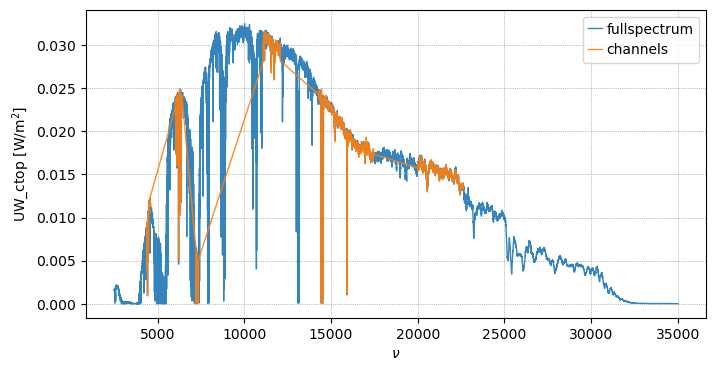

In [23]:
#fdir = "/home/dengnan/Documents/git_store/SW_RTM/GOES_data/RTM_10000/" 
fdir ="./GOES_data/RTM_10000/"
bandmode = ['fullspectrum','channels']
filename = '/'+ 'Results_case2_AOD=0.1243_COD=10_kap=[10, 11, 12]_th0=32.npy'


#items = [0,1,2,6,5,4,3]
UW_sum=[]
fig = plt.figure(figsize=(8,4))
gs1 = gridspec.GridSpec(1, 1) 
gs1.update(wspace=0.1, hspace=0.15)
ax1 = fig.add_subplot(gs1[0])
nu0 = np.arange(2500, 35000, 3)
channels = ['C{:02d}'.format(c) for c in range(1, 6 + 1)]
for i in range(2):
    if bandmode[i] == 'channels':
        nu = goes_calinu(nu, channels, './GOES_data/', dnu=3)
    else:
        nu = nu0
    file = fdir + bandmode[i] + filename
    results = np.load(file, allow_pickle=True).item()
    Fuw_ctop=results.get('F_uw')
    ax1.plot(nu, Fuw_ctop, label=f'{bandmode[i]}',linewidth=1,alpha=0.9)
    if bandmode[i] == 'channels':
        print('spectral model',np.trapz(Fuw_ctop,nu))
    else:
        nu_input = goes_calinu(nu0, channels, './GOES_data/', dnu=3)
        idx = np.nonzero(np.isin(nu0, nu_input))[0]
        print('full spectral',np.trapz(Fuw_ctop[idx],nu[idx]))
    
ax1.set_xlabel(r"$\nu$")

ax1.set_ylabel(r"UW_ctop [W/m$^2$]")
ax1.grid(color='grey', linestyle=':', linewidth=0.5)

ax1.legend(loc='upper right', ncol=1, columnspacing=0.5,handlelength=1,handletextpad=0.3)

plt.show()
#fig.savefig('COD_UW_ctop_spectrum.png', dpi=300, bbox_inches='tight')

In [25]:
data = np.genfromtxt('data/profiles/SolarTOA.csv', delimiter=',')
ref_lam = data[:, 0]  # in unit of um
ref_E = data[:, 1]  # in unit of W/m2 um
ref_E_nu = -ref_E*ref_lam**2/1e4

C01
spectral model 39.84165357472757
F_dw_os 115.17553045310588
F_dw_os 115.17553045310588
full spectral 39.85206407185581
Relative diff -0.026122855542596624%
C02
spectral model 63.1270953324325
F_dw_os 207.56729225738547
F_dw_os 207.56729225738547
full spectral 63.20148082969297
Relative diff -0.11769581390174927%
C03
spectral model 29.891888269178388
F_dw_os 73.10852126328729
F_dw_os 73.10852126328729
full spectral 29.93823284259332
Relative diff -0.15480063121493365%
C04
spectral model 0.3896406343332855
F_dw_os 10.192619074253713
F_dw_os 10.192619074253713
full spectral 0.39117766980860724
Relative diff -0.39292515753104634%
C05
spectral model 8.875667670528571
F_dw_os 24.59154193402565
F_dw_os 24.59154193402565
full spectral 8.887417085971354
Relative diff -0.1322028135860606%
C06
spectral model 1.803695434810215
F_dw_os 7.15265009366242
F_dw_os 7.15265009366242
full spectral 1.8026611857728791
Relative diff 0.05737345683694944%


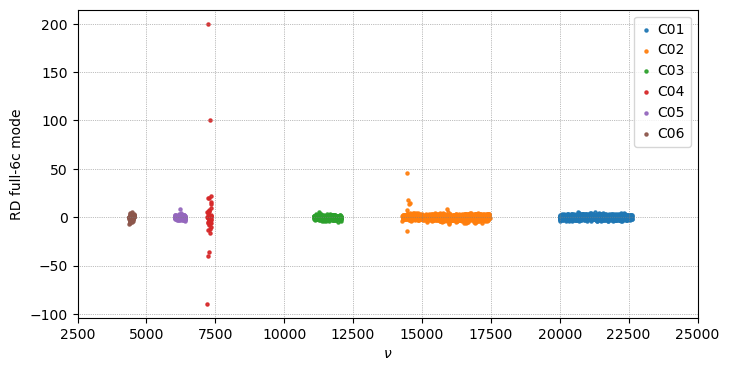

In [28]:
#fdir = "/home/dengnan/SW_RTM/GOES_data/RTM/" 
fdir ="./GOES_data/RTM_10000/"
bandmode = ['channels','fullspectrum',]
filename = '/'+ 'Results_case2_AOD=0.1243_COD=10_kap=[10, 11, 12]_th0=32.npy'

#items = [0,1,2,6,5,4,3]
UW_sum=[]
fig = plt.figure(figsize=(8,4))
gs1 = gridspec.GridSpec(1, 1) 
gs1.update(wspace=0.1, hspace=0.15)
ax1 = fig.add_subplot(gs1[0])
nu0 = np.arange(2500, 35000, 3)
channels = ['C{:02d}'.format(c) for c in range(1, 6 + 1)]
nu_6c = goes_calinu(nu0, channels, './GOES_data/', dnu=3)

for channel in channels:
    for i in range(2):
        file = fdir + bandmode[i] + filename
        results = np.load(file, allow_pickle=True).item()
        Fuw_ctop=results.get('F_uw')
        nu_input = goes_calinu(nu0, [channel], './GOES_data/', dnu=3)
        if bandmode[i] == 'channels':
            idx = np.nonzero(np.isin(nu_6c,nu_input))[0]
            print(channel)
            F_6c = np.trapz(Fuw_ctop[idx],nu_input)
            print('spectral model',F_6c)
            #ax1.plot(nu, Fuw_ctop, label=f'{bandmode[i]}',linewidth=1,alpha=0.9)
            Fuw_ctop_6c = Fuw_ctop[idx]
            F_dw_os = -np.interp(-nu_input,-1e4/ref_lam, ref_E_nu) 
            print('F_dw_os',np.trapz(F_dw_os,nu_input))
        else:
            nu = nu0
            nu_input = goes_calinu(nu0, [channel], './GOES_data/', dnu=3)
            idx = np.nonzero(np.isin(nu0,nu_input))[0]
            F_ = np.trapz(Fuw_ctop[idx],nu_input)
            F_dw_os = -np.interp(-nu_input,-1e4/ref_lam, ref_E_nu) 
            print('F_dw_os',np.trapz(F_dw_os,nu_input))
            print('full spectral',F_)
            print('Relative diff', f"{(F_6c-F_) /F_*100}%")
            ax1.scatter(nu[idx], (Fuw_ctop_6c-Fuw_ctop[idx])/Fuw_ctop[idx]*100, label=f'{channel}',s=5, alpha=0.9)
ax1.set_xlabel(r"$\nu$")
ax1.set_xlim(2500,25000)
ax1.set_ylabel(r"RD full-6c mode")
ax1.grid(color='grey', linestyle=':', linewidth=0.5)

ax1.legend(loc='upper right', ncol=1, columnspacing=0.5,handlelength=1,handletextpad=0.3)

plt.show()
#fig.savefig('COD_UW_ctop_spectrum.png', dpi=300, bbox_inches='tight')

### fuc

In [3]:
def nearealtime_RTM(sun_zen, local_zen, rela_azi, COD_guess, T_a, RH, channels, file_dir, bandmode):
    # Round values to two decimal places
    sun_zen = round(sun_zen, 0)
    local_zen = round(local_zen, 0)
    rela_azi = round(rela_azi, 0)
    COD_guess = round(COD_guess, 0)
    T_a = round(T_a, 0)
    RH = round(RH, 0)
    
    uw_rxyz_file = f"uwxyzr_COD={COD_guess}_th0={sun_zen}_Ta={T_a}_RH={RH}.npy"
    #bandmode = 'GOES' # GOES
    # print(bandmode)
    if bandmode == 'GOES':
        uw_rxyz_path = os.path.join(file_dir, 'RTM/channels', uw_rxyz_file)
        #results = np.load(uw_rxyz_path, allow_pickle=True).item()
        #uw_rxyz_M = results.get('uw_rxyz_M')
        #print(len(uw_rxyz_M[1629]))
    else:
        uw_rxyz_path = os.path.join(file_dir, 'RTM/fullspectrum', uw_rxyz_file)
        # results = np.load(uw_rxyz_path, allow_pickle=True).item()
        # uw_rxyz_M = results.get('uw_rxyz_M')
        #print(len(uw_rxyz_M[4986]))
    if not os.path.exists(uw_rxyz_path):
        print(f"File {uw_rxyz_file} not found. Running RTM...")
        run_RTM(sun_zen, COD_guess, T_a, RH, file_dir, channels, bandmode)
    results = np.load(uw_rxyz_path, allow_pickle=True).item()
    uw_rxyz_M = results.get('uw_rxyz_M')
    #df_channel_ref1 = RTM_preprocess(uw_rxyz_M, sun_zen, local_zen, rela_azi, channels, file_dir, 'rad', 'full')

    df_channel_ref = RTM_preprocess(uw_rxyz_M, sun_zen, local_zen, rela_azi, channels, file_dir, 'rad', bandmode)

    return df_channel_ref

In [4]:
def RTM_preprocess(uw_rxyz_M, Sun_zen, local_zen, rela_azi, channels, file_dir, outputtype = 'rad', bandmode = 'GOES'):
    # 1. convert GOES channel
    # 2. Convert channal radiance to 2D reflectance
    # 3. select [local_zenith, relative_azimuth]
    #from LBL_funcs_utl import *
    data = np.genfromtxt('data/profiles/SolarTOA.csv', delimiter=',')
    ref_lam = data[:, 0]  # in unit of um
    ref_E = data[:, 1]  # in unit of W/m2 um
    ref_E_nu = -ref_E * ref_lam ** 2 / 1e4
    # nu = np.arange(2500, 35000, 3)
    # F_dw_os = -np.interp(-nu, -1e4 / ref_lam, ref_E_nu)
    # from LBL_funcs_utl import plot_3D_AngDist
    # theta_index, phi_index = find_bin_indices(local_zen, rela_azi, 'both')
    # H = plot_3D_AngDist(3, 10, Sun_zen, 0, uw_rxyz_M, nu, F_dw_os, 1000,
    #                     'full', is_flux=False,Norm=False)
    # print(H[theta_index, phi_index])

    # convert to intensity
    #channels = ['C{:02d}'.format(c) for c in range(1, 6 + 1)]
    n = len(channels)
    df = pd.DataFrame(data=[[0.0] * n], columns=channels)
    dnu = 3  # spectral resolution 0.1 is enough, 0.01 is too fine, especially for cloudy periods
    nu = np.arange(2500, 35000, dnu)
    if bandmode == 'full':
        # LBL
        nu_input = nu
    else:
        # 6 channels
        nu_input = goes_calinu(nu, channels, file_dir, dnu=3)
    for channel in channels:
        # load calibration data : Spectral Response Func
        channel_number = int(channel[-2:])
        dirpath = file_dir+'GOES-R_ABI_FM2_SRF_CWG/'
        channel_srf = os.path.join(dirpath,
            'GOES-R_ABI_FM2_SRF_CWG_ch{}.txt'.format(channel_number))
        calibration = np.genfromtxt(channel_srf, skip_header=2)
        # calibration_wl = calibration[:, 0]  # wavelength [um]
        calibration_nu = calibration[:, 1]  # cm-1
        # print(calibration_nu.min(),calibration_nu.max())
        calibration_srf = calibration[:, 2] # relative SRF [-]
        nu_channel = goes_calinu(nu, [channel], file_dir, dnu=3)
        # reverse order (so wavenumber is increasing)
        calibration_nu = calibration_nu[::-1]
        calibration_srf = calibration_srf[::-1]
        # Solor TOA and surface albedo
        F_dw_os_channel = -np.interp(-nu_channel, -1e4 / ref_lam, ref_E_nu)  # in wavenumber basis
        # interpolate calibration to match model
        srf = np.interp(nu_channel, calibration_nu, calibration_srf)
        # Normalize SRF if necessary
        F_dw_os_SRF = np.multiply(F_dw_os_channel, srf)

        # Integrate spectral radiance over the channel
        # Channal 2D radiance [W/m2/sr]
        nu_idx = np.nonzero(np.isin(nu_input,nu_channel))[0] # fixed 1 April.

        print(channel)
        result = [uw_rxyz_M[i] for i in nu_idx]
        # if channel == 'C02':
        #     print('uw_rxyz_M[inx=100]',len(uw_rxyz_M[nu_idx[100]]))
        #     print(len(result[100]))
        #     #print("nu_channel",nu_channel)
        #     # print("nu_channel.shape", nu_channel.shape)
        #     print('nu_idx',nu_idx)
        #     print("nu_input.shape", nu_input.shape)
        #     print('nu_input[nu_idx]', nu_input[nu_idx],nu_input[nu_idx].shape)
        #     # print('F_dw_os_channel', F_dw_os_channel)
        #     # print('F_dw_os_SRF',np.trapz(F_dw_os_SRF,nu_channel))
        OSWR_channel = cal_mono_Intensity(result, Sun_zen, nu_input[nu_idx], F_dw_os_SRF, local_zen, rela_azi,
                                          is_flux=False, Norm=False, dirc='UW')
        if outputtype != 'rad':
            F_dw_os_channal = np.trapz(F_dw_os_channel, nu_channel)
            # need sun-earth distance correction, will be done in extract_sta_oswr
            ref_OSWR_channel = OSWR_channel * np.pi / F_dw_os_channal  # reflectance
            df.loc[0, f"C0{channel_number}"] = ref_OSWR_channel
        else: # Rad
            df.loc[0, f"C0{channel_number}"] = OSWR_channel
    return df

In [ ]:
def cal_mono_Intensity(rxyz_M, theta0, nu, F_dw_os, local_zen, rela_azi, N_bundles=1000, is_flux=False, Norm=False,
                       dirc='UW'):  # Z_csky
    """
    bins_theta: local zenith angle
    bin_phi: relative difference between the angle of solar azimuth and local zimuth
    solid anlge (bin_theta,bin_phi) determined to the intensity at an angle of (satellite local solar).
    rxyz_M : the vector of each photon fall on the ground. Each band saved many photons, 
            we sum the number of photon, multiple with ratio to get  the flux.
    F_dw_os: the downwelling flux at TOA on each nu
    """
    theta0 = theta0 / 180 * math.pi
    phi0 = 0 / 180 * math.pi

    d_th = 2
    d_phi = 5
    # GOES solar zenith 45, local zenith angle 45, relative azimuth difference angle 45
    bins_theta = np.arange(0, 91, 2)
    # symmetric, so we change (-180, 180) to (0, 180)
    bins_phi = np.hstack((np.arange(0, 170 + 5, 5), np.arange(170, 180 + 1, 1)))
    fw_rx, fw_ry, fw_rz, uw_rx, uw_ry, uw_rz = [np.zeros((N_bundles + 10, len(nu))) * np.nan for _ in range(6)]
    H = np.zeros((len(bins_theta) - 1, len(bins_phi) - 1))
    for i in range(len(rxyz_M)):
        fw_rxyz = rxyz_M[i]
        N_dw = len(fw_rxyz)
        fw_rx[0:N_dw, i] = np.array([x[0] for x in fw_rxyz])
        fw_ry[0:N_dw, i] = np.array([x[1] for x in fw_rxyz])
        fw_rz[0:N_dw, i] = np.array([x[2] for x in fw_rxyz])
        if dirc == 'UW':
            theta_v, phi_v = theta_phi(fw_rx[:, i], fw_ry[:, i], fw_rz[:, i])
        else:  # DW
            theta_v, phi_v = theta_phi(fw_rx[:, i], fw_ry[:, i], -fw_rz[:, i])
        ind = np.isnan(phi_v)
        theta_v = theta_v[~ind]
        phi_v = phi_v[~ind] - phi0
        phi_v[phi_v > math.pi] -= 2 * math.pi
        H_i, xedges, yedges = np.histogram2d(np.rad2deg(theta_v), np.rad2deg(phi_v), bins=(bins_theta, bins_phi))
        if Norm:
            H += H_i * np.cos(theta0) * 1 / N_bundles  # *F_dw_os[k]*3/N_bundles # 3 is dnu
        else:
            H += H_i * np.cos(theta0) * F_dw_os[i] * 3 / N_bundles # flux W/m2
    theta_, phi_ = np.meshgrid(xedges[0:-1], yedges[0:-1])
    if not is_flux: # if the output should be radiance.
        ths = np.deg2rad(theta_.T + d_th / 2)  # rad dw # division 2 for the 2sintcost
        print('Flux',np.sum(H))
        H /= 0.5 * np.sin(2 * ths)
    H /= np.deg2rad(d_th) * np.deg2rad(d_phi)  # per solid angle, in the direction of beam
    theta_idx, phi_idx = find_bin_indices(local_zen, rela_azi, 'both')
    print('Intensity',np.sum(H))
    print('In_ang',H[theta_idx, phi_idx])
    # GOES angular resolution (approximate)
    # goes_theta_H = 56e-6  # radians (56 microradians)
    # goes_theta_V = 56e-6  # Assuming similar vertical resolution for simplicity
    # Your function's angular resolution
    # d_th = np.deg2rad(2)
    # d_phi = np.deg2rad(5)
    # Calculate solid angles
    # goes_solid_angle = goes_theta_H * goes_theta_V
    # my_solid_angle = d_th * d_phi
    # Adjust radiance to match GOES solid angle
    # adjusted_radiance = H[theta_idx, phi_idx] * (goes_solid_angle / your_solid_angle)
    # print(H[theta_idx, phi_idx],
    #       interpolate_with_neighbors(H, theta_idx, phi_idx))
    return interpolate_with_neighbors(H, theta_idx, phi_idx)

## 1. COD updated only based on C02

In [ ]:
for i in range(sat_ref.shape[0]):
    print('Column',f"{i+1}",'of',sat_ref.shape[0])
    Sun_Zen = sat['Sun_Zen'][i]
    T_a = sat['temp'][i] + 273.15  # Convert to Kelvin
    RH = sat['rh'][i]
    try:
        local_zen = sat['Local_Ze'][i]
        rela_azi = sat['rela_azi'][i]
    except KeyError:
        local_zen = sat['local_Zen'][i]
        rela_azi = sat['rela_azi'][i]
    pd_data = sat_ref.iloc[i] # Directly access the scalar value
    # [W/m2/sr/um] -> [W/m2/sr]
    Rc_real = pd_data

    max_iterations = 2+5
    epsilon = 2
    max_cod = 50.0
    min_cod = 0.0
    N_bundles = 10000
    #return sat

    print(f"{'Iteration':<10} {'COD':<10} {'C01':<10} {'C02':<10} {'C03':<10} {'C04':<10} {'C05':<10} {'C06':<10} {'MSE':<10} {'RMSE':<10}")

    Rc_rtm_df = pd.DataFrame()
    RMSE_df = pd.DataFrame()
    COD_list = [10,20]#,30.0]

    for COD_guess in COD_list:
        Rc_rtm = nearealtime_RTM(Sun_Zen, local_zen, rela_azi, COD_guess, T_a,
                                 RH, channels, file_dir=data_dir, bandmode='full',
                                 N_bundles=N_bundles)
        SE, MSE, RMSE = loss_function(Rc_real, Rc_rtm)

        RMSE_df = pd.concat([RMSE_df, RMSE], ignore_index=True)
        Rc_rtm_df = pd.concat([Rc_rtm_df, Rc_rtm], ignore_index=True)  # always append to the end

        print(f"{np.nan:<10} {COD_guess:<10.2f} "
          f"{SE['C01'].iloc[-1]:<10.4f} "
          f"{SE['C02'].iloc[-1]:<10.4f} "
          f"{SE['C03'].iloc[-1]:<10.4f} "
          f"{SE['C04'].iloc[-1]:<10.4f} "
          f"{SE['C05'].iloc[-1]:<10.4f} "
          f"{SE['C06'].iloc[-1]:<10.4f} "
          f"{MSE:<10.4f} "
          f"{RMSE:<10.4f}")
        if RMSE < epsilon:
            sat.at[i, 'COD_rtm'] = COD_guess
            #print('break')
            break

    nearInd = np.argmin(RMSE_df['C02'])
    gradient = (Rc_rtm_df.iloc[1] - Rc_rtm_df.iloc[0]) / (COD_list[1] - COD_list[0])
    COD = (Rc_real - Rc_rtm_df.iloc[nearInd]) / gradient + COD_list[nearInd]
    COD_guess = round(float(COD['C02']), 2)
    #print(COD_guess)

    for j in range(max_iterations):
        COD_list.append(COD_guess)
        Rc_rtm = nearealtime_RTM(Sun_Zen, local_zen, rela_azi, COD_guess, T_a,
                                 RH, channels, file_dir=data_dir,bandmode='full',N_bundles=N_bundles)
        SE, MSE, RMSE = loss_function(Rc_real, Rc_rtm)
        #print("--" * 20)
        # print(f"Iteration {j-2}, COD = {COD_list[j]}, MSE: {MSE}, RMSE: {RMSE}\n Square Error =\n {error}")

        Rc_rtm_df = pd.concat([Rc_rtm_df, Rc_rtm], ignore_index=True)
        RMSE_df = pd.concat([RMSE_df, RMSE], ignore_index=True)
        print(f"{j:<10} {COD_list[-1]:<10.2f} "
              f"{SE['C01'].iloc[-1]:<10.4f} "
              f"{SE['C02'].iloc[-1]:<10.4f} "
              f"{SE['C03'].iloc[-1]:<10.4f} "
              f"{SE['C04'].iloc[-1]:<10.4f} "
              f"{SE['C05'].iloc[-1]:<10.4f} "
              f"{SE['C06'].iloc[-1]:<10.4f} "
              f"{MSE:<10.4f} "
              f"{RMSE:<10.4f}")
        if RMSE < epsilon:
            sat.at[i, 'COD_rtm'] = COD_guess
            #print('break')
            break
        COD_guess,COD = compute_gradient_simple(Rc_rtm_df, COD_list, Rc_real, RMSE_df, RMSE,)
        #COD_guess = compute_cod_regression(Rc_rtm_df, COD_list, Rc_real, 'C02')
        # Assuming this is inside your loop

        # f"RTM: {Rc_rtm.values.round(4)}\n", "", f"Real: {[round(val, 4) for val in Rc_real]}")
        if COD_guess > max_cod:
            print(f'COD is higher than {max_cod}')
            COD_guess = COD_list[np.argmin(RMSE_df['C02'])]
            sat.at[i, 'COD_rtm'] = COD_guess
            break
        if COD_guess < min_cod:
            print(f'COD is lower than {min_cod}')
            COD_guess = COD_list[np.argmin(RMSE_df['C02'])]
            sat.at[i, 'COD_rtm'] = COD_guess
            break

    if j == max_iterations-1:
        COD_guess = COD_list[np.argmin(RMSE_df['C02'])]
        sat.at[i, 'COD_rtm'] = COD_guess
    print(f"Final COD: {COD_guess:.4f}")

Column 1 of 12
Iteration  COD        C01        C02        C03        C04        C05        C06        MSE        RMSE      
nan        0.00       89.7101    286.1154   11.5306    0.0075     0.4877     0.0223     64.6456    8.0403    
nan        10.00      15.7267    57.0250    1.3362     0.0009     0.0086     0.0111     12.3514    3.5145    
nan        20.00      1.3352     17.7261    0.0461     0.0033     0.0007     0.0014     3.1855     1.7848    
File uwxyzr_COD=24_th0=32_Ta=299_RH=61.npy not found. Running RTM...
Start MonteCarlo once.
CPU time: 1377.3608539104462
0          24.50      1.2680     6.0819     0.1930     0.0202     0.0022     0.0003     1.2609     1.1229    
Final COD: 24.5000
Column 2 of 12
Iteration  COD        C01        C02        C03        C04        C05        C06        MSE        RMSE      
File uwxyzr_COD=0_th0=33_Ta=299_RH=60.npy not found. Running RTM...
Start MonteCarlo once.
CPU time: 1333.5577938556671
nan        0.00       93.5711    321.6301   12.705

KeyboardInterrupt: 

In [1]:
sat[['COD','COD_rtm']].plot(style='o-')
plt.xlabel('site')  # Set x-axis label to COD
plt.ylabel('COD')  # Set y-axis label to Radiance
plt.grid(True)
plt.title('full spectrum')
plt.legend(title='Components')
plt.show()

NameError: name 'sat' is not defined

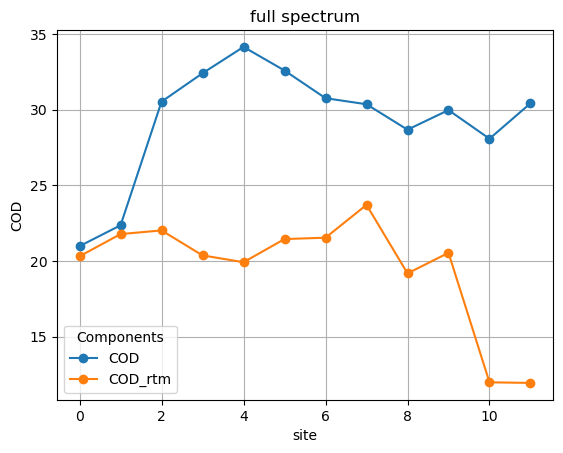

In [9]:
sat[['COD','COD_rtm']].plot(style='o-')
plt.xlabel('site')  # Set x-axis label to COD
plt.ylabel('COD')  # Set y-axis label to Radiance
plt.grid(True)
plt.title('full spectrum')
plt.legend(title='Components')
plt.show()

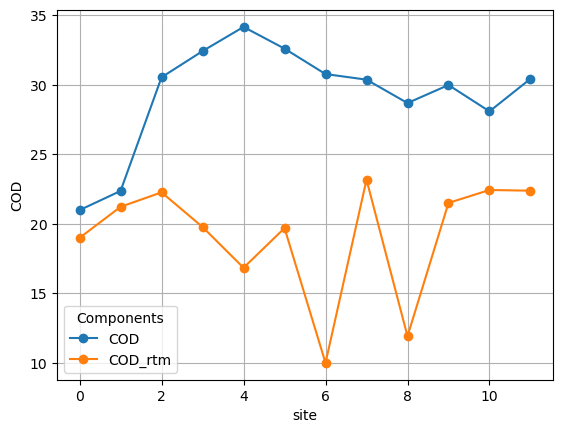

In [166]:
sat[['COD','COD_rtm']].plot(style='o-')
plt.xlabel('site')  # Set x-axis label to COD
plt.ylabel('COD')  # Set y-axis label to Radiance
plt.grid(True)
plt.legend(title='Components')
plt.show()

## 2. COD = COD of all channel)

In [ ]:
Rc_real - Rc_rtm_df

C01    13.417493
C02    22.219933
C03     6.185244
C04     0.001027
C05     1.434745
C06     0.328054
Name: 3, dtype: float64

In [35]:
Rc_rtm_df

,C01,C02,C03,C04,C05,C06
0,4.557848,5.603091,1.866834,0.096509,0.413684,0.119911
1,8.960032,12.691208,4.562930,0.062930,1.811884,0.252723
2,9.904425,16.320879,4.269621,0.044996,1.281810,0.205501


In [ ]:
def cost_function(Rc_real, Rc_rtm):
    """
    Calculate the cost function (RMSE) between the real and RTM reflectance.
    Is not used, Derivative of the cost function is used to update the COD guess.
    
    """
    # Calculate the RMSE between the real and RTM reflectance
    error = Rc_real - Rc_rtm
    mse = (error ** 2).to_numpy().mean()
    rmse = np.sqrt(mse)
    return rmse

In [ ]:
def compute_gradient(x, y, w, b, w0): 
    """
    Computes the gradient for linear regression 
    y = wx + b
    Args:
      x (ndarray (m,)): Nor Radiance
      y (ndarray (m,)): COD, m=6 examples 
      w,b (scalar)    : model parameters  
    Returns
      dj_dw (scalar): The gradient of the cost w.r.t. the parameters w
      dj_db (scalar): The gradient of the cost w.r.t. the parameter b     
     """
    
    # Number of training examples
    m = x.shape[0]    
    dj_dw = 0
    dj_db = 0
    
    for i in range(m):  
        f_wb = w * x[i] + b 
        dj_dw_i = (f_wb - y[i]) * x[i] 
        dj_db_i = f_wb - y[i] 
        dj_db += dj_db_i
        dj_dw += dj_dw_i 
    dj_dw = dj_dw / m 
    dj_db = dj_db / m 
        
    return dj_dw, dj_db

In [ ]:
a = [0.3,0.6,0.07,0.01,0.01,0.01]
def compute_gradient_simple(Rc_rtm_df, COD_list, Rc_real, RMSE_df, RMSE):
    """
    Linear fitting of COD, based on two nearest neighbors of Rc_real.
    """
    a = [0.3,0.6,0.07,0.01,0.01,0.01]
    a1,a2,a3,a4,a5,a6 = a
    sorted_indices = np.argsort(RMSE_df['C02'].values) # ascendent order
    nearest_indices = sorted_indices[:2]
    
    # Sort nearest indices to ensure consistent order
    # nearest_indices.sort()
    Rc1, Rc2 = Rc_rtm_df.iloc[nearest_indices[0]], Rc_rtm_df.iloc[nearest_indices[1]]
    COD1, COD2 = COD_list[nearest_indices[0]], COD_list[nearest_indices[1]]
    # Compute the gradient using the two nearest points
    gradient = (Rc2 - Rc1) / (COD2 - COD1) 
    # Calculate the COD at Rc_real using the linear approximation
    if RMSE < 0.1:
        unit_vector = gradient / gradient.abs()
        unit_vector = unit_vector.fillna(0)  # Replace any NaNs with 0 in case of zero gradients
        print('RMSE', RMSE)
        learningrate = RMSE
        COD = COD1 + learningrate * unit_vector
    else:
        COD = COD1 + (Rc_real - Rc1) / gradient

    # Debug logging
    #print(f"Debug: Gradient:\n {gradient}, COD_estimate:\n {COD}")
    print(COD)
    COD.replace([np.inf, -np.inf], np.nan, inplace=True)
    #COD_guess = np.nanmean(COD[['C01','C02']])  #round(float(COD['C02']), 2)
    COD_guess = np.sum(COD*a)
    
    if COD_guess <= 0:
        print("COD must be greater than 0, but got {}.".format(COD_guess))
    return COD_guess, COD
for i in range(4,5):#sat_ref.shape[0]):
    print('Column',f"{i}",'of',sat_ref.shape[0])
    Sun_Zen = sat['Sun_Zen'][i]
    T_a = sat['temp'][i] + 273.15  # Convert to Kelvin
    RH = sat['rh'][i]
    try:
        local_zen = sat['Local_Ze'][i]
        rela_azi = sat['rela_azi'][i]
    except KeyError:
        local_zen = sat['local_Zen'][i]
        rela_azi = sat['rela_azi'][i]
    pd_data = sat_ref.iloc[i] # Directly access the scalar value
    # [W/m2/sr/um] -> [W/m2/sr]
    Rc_real = min_max_nor(pd_data)

    max_iterations = 5
    epsilon = 2
    max_cod = 50.0
    min_cod = 0.0
    #return sat

    print(f"{'Iteration':<10} {'COD':<10} {'C01':<10} {'C02':<10} {'C03':<10} {'C04':<10} {'C05':<10} {'C06':<10} {'MSE':<10} {'RMSE':<10}")

    Rc_rtm_df = pd.DataFrame()
    RMSE_dic = []
    COD_list = [10,20]#,30.0]

    for COD_guess in COD_list:
        Rc_rtm_ = nearealtime_RTM(Sun_Zen, local_zen, rela_azi, COD_guess, T_a, RH, 
                                 channels, file_dir=data_dir,bandmode='GOES', N_bundles=N_bundles)
        Rc_rtm = min_max_nor(Rc_rtm_)
        SE, MSE, RMSE = loss_function(Rc_real, Rc_rtm)

        RMSE_dic.append(RMSE)
        Rc_rtm_df = pd.concat([Rc_rtm_df, Rc_rtm], ignore_index=True)  # always append to the end

        print(f"{np.nan:<10} {COD_guess:<10.2f} "
          f"{MSE:<10.4f} "
          f"{RMSE:<10.4f}")
        if RMSE < epsilon:
            sat.at[i, 'COD_rtm_6cave'] = COD_guess
            #print('break')
            break

    nearInd = np.argmin(RMSE_df['C02'])
    w0 = (Rc_rtm_df.iloc[1] - Rc_rtm_df.iloc[0]) / (COD_list[1] - COD_list[0])
    COD = (Rc_real - Rc_rtm_df.iloc[nearInd]) / gradient + COD_list[nearInd]
    # COD.replace([np.inf, -np.inf], np.nan, inplace=True)
    # COD_guess = np.sum(COD*a)  #round(float(COD['C02']), 2)
    #print(COD_guess)

    # for j in range(max_iterations):
    #     COD_list.append(COD_guess)
    #     Rc_rtm = nearealtime_RTM(Sun_Zen, local_zen, rela_azi, COD_guess, T_a, RH, channels, file_dir=data_dir, bandmode='full')
    #     SE, MSE, RMSE = loss_function(Rc_real, Rc_rtm)
    #     #print("--" * 20)
    #     # print(f"Iteration {j-2}, COD = {COD_list[j]}, MSE: {MSE}, RMSE: {RMSE}\n Square Error =\n {SE}")

    #     Rc_rtm_df = pd.concat([Rc_rtm_df, Rc_rtm], ignore_index=True)
    #     RMSE_dic.append(RMSE)
    #     print(f"{j:<10} {COD_list[-1]:<10.2f} "
    #           f"{SE['C01'].iloc[-1]:<10.4f} "
    #           f"{SE['C02'].iloc[-1]:<10.4f} "
    #           f"{SE['C03'].iloc[-1]:<10.4f} "
    #           f"{SE['C04'].iloc[-1]:<10.4f} "
    #           f"{SE['C05'].iloc[-1]:<10.4f} "
    #           f"{SE['C06'].iloc[-1]:<10.4f} "
    #           f"{MSE:<10.4f} "
    #           f"{RMSE:<10.4f}")
    #     if RMSE < epsilon:
    #         sat.at[i, 'COD_rtm_6cave'] = COD_guess
    #         #print('break')
    #         break
    #     COD_guess,COD = compute_gradient_simple(Rc_rtm_df, COD_list, Rc_real, RMSE_df, RMSE)
    #     #COD_guess = compute_cod_regression(Rc_rtm_df, COD_list, Rc_real, 'C02')

    #     # f"RTM: {Rc_rtm.values.round(4)}\n", "", f"Real: {[round(val, 4) for val in Rc_real]}")
    #     if COD_guess > max_cod:
    #         print(f'COD is higher than {max_cod}')
    #         COD_guess = COD_list[np.argmin(RMSE_df['C02'])]
    #         sat.at[i, 'COD_rtm_6cave'] = COD_guess
    #         break
    #     if COD_guess < min_cod:
    #         print(f'COD is lower than {min_cod}')
    #         COD_guess = COD_list[np.argmin(RMSE_df['C02'])]
    #         sat.at[i, 'COD_rtm_6cave'] = COD_guess
    #         break

    # if j == max_iterations-1:
    #     COD_guess = COD_list[np.argmin(RMSE_df['C02'])]
    #     sat.at[i, 'COD_rtm_6cave'] = COD_guess
    # print(f"Final COD: {COD_guess:.4f}")

Column 4 of 12
Iteration  COD        C01        C02        C03        C04        C05        C06        MSE        RMSE      
nan        10.00      0.0801     0.0439     0.1414     0.0291     0.0016     0.0340     0.0550     0.2346    


In [28]:
error

,C01,C02,C03,C04,C05,C06
0,0.080107,0.043911,0.141402,0.029088,0.001569,0.034004


In [30]:
MSE,RMSE


(0.05501374077578749, 0.23455008159407553)

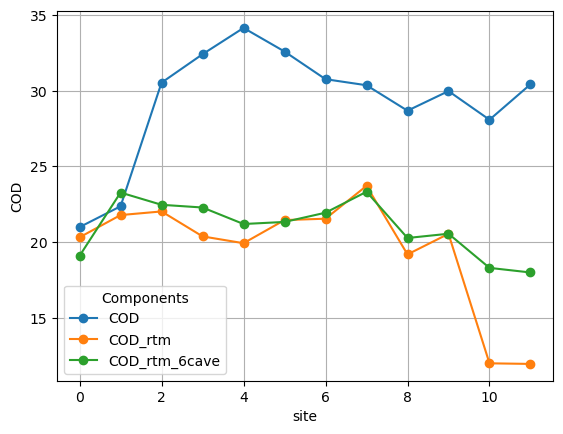

In [12]:
sat[['COD','COD_rtm','COD_rtm_6cave']].plot(style='o-')
plt.xlabel('site')  # Set x-axis label to COD
plt.ylabel('COD')  # Set y-axis label to Radiance
plt.grid(True)
plt.legend(title='Components')
plt.show()

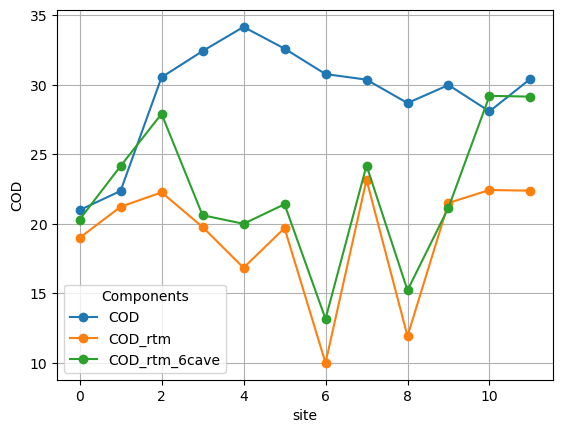

In [167]:
sat[['COD','COD_rtm','COD_rtm_6cave']].plot(style='o-')
plt.xlabel('site')  # Set x-axis label to COD
plt.ylabel('COD')  # Set y-axis label to Radiance
plt.grid(True)
plt.legend(title='Components')
plt.show()

In [13]:
COD

C01     13.507595
C02     11.936651
C03     15.734504
C04   -161.440129
C05      6.988056
C06    721.344050
dtype: float64

In [14]:
Rc_rtm_df

,C01,C02,C03,C04,C05,C06
0,1.213610,4.457396,2.512248,0.092247,0.774273,0.162805
1,9.105039,17.084181,4.367680,0.097898,1.583391,0.164789
2,8.817895,21.356423,6.215478,0.080443,1.236418,0.135432


### Min max normalization

In [3]:
import pandas as pd
import os

filedir = './GOES_tool/BON_ABI-L1b-RadC_cropped_Rad_2019/'


channels = ['C01', 'C02', 'C03', 'C04', 'C05', 'C06']

# Prepare a list to store the results
results = []

for channel in channels:
    site = f'2019_June_BON_{channel}_Rad.csv'
    file_path = os.path.join(filedir, site)  # Use os.path.join for robust path creation

    try:
        df = pd.read_csv(file_path)
        df_selected = df['Radiance']

        min_value = df_selected.min()  # Calculate min and max
        max_value = df_selected.max()

        results.append({'channel': channel, 'min': min_value, 'max': max_value})  # Store in results list

    except FileNotFoundError:
        print(f"File not found: {file_path}")  # Handle missing files
    except KeyError:
        print(f"Channel {channel} not found in {file_path}") #Handle missing columns
    except Exception as e:
        print(f"An error occurred processing {file_path}: {e}") #Catch other potential errors

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

output_file = 'min_max_values.csv'  # Name of the output file
# Save the DataFrame to a CSV file
results_df.to_csv(filedir+output_file, index=False)  # index=False to prevent writing the DataFrame index
print(f"Min/Max values saved to {output_file}")

Min/Max values saved to min_max_values.csv


In [4]:
# load min max values
results = pd.read_csv(filedir + 'min_max_values.csv')
results

,channel,min,max
0,C01,61.770844,531.980400
1,C02,31.886980,386.340940
2,C03,45.629974,239.739930
3,C04,0.075152,53.335655
4,C05,10.064993,31.907400
5,C06,2.529312,8.276211


In [5]:
def min_max_nor(pd_data, sys='mac'):
    if sys == 'linux':
        sysdir = '/home/dengnan/SW_RTM/'
    elif sys == 'mac': 
        sysdir = '/Users/dengnan/Documents/git_store/Shortwave_MCRTM/'
    filedir = sysdir + 'GOES_tool/BON_ABI-L2-CODC_cropped_COD_2019/'
    results = pd.read_csv(filedir + 'min_max_values.csv', index_col=0)

    channels = ['C01', 'C02', 'C03', 'C04', 'C05', 'C06']
    pd_new = pd_data.copy()
    for channel in channels:
        max_v = results.loc[channel, 'Max']
        min_v = results.loc[channel, 'Min']
        # min - max normalization
        pd_new[channel] = (pd_data[channel] - min_v) / (max_v - min_v)

    return pd_new

In [12]:
pd_data

C01    12.993524
C02    21.523911
C03     6.055318
C04     0.001027
C05     1.439065
C06     0.330822
Name: 2, dtype: float64

In [13]:
min_max_nor(pd_data)

C01    0.631238
C02    0.686071
C03    0.561702
C04    0.001027
C05    0.479688
C06    0.330822
Name: 2, dtype: float64

## 3. COD update based on C01,C02,C03

In [ ]:
a = [1,1,1,1,1]#[0.3,0.5,0.2,0.00,0.00,0.00]
N_bundles = 1000
bandmode = 'GOES'
def compute_gradient_simple(Rc_rtm_df, COD_list, Rc_real, RMSE_df, RMSE):
    """
    Linear fitting of COD, based on two nearest neighbors of Rc_real.
    """
    a = [0.3,0.6,0.07,0.01,0.01,0.01]
    a1,a2,a3,a4,a5,a6 = a
    sorted_indices = np.argsort(RMSE_df['C02'].values) # ascendent order
    nearest_indices = sorted_indices[:2]
    # Sort nearest indices to ensure consistent order
    # nearest_indices.sort()
    Rc1, Rc2 = Rc_rtm_df.iloc[nearest_indices[0]], Rc_rtm_df.iloc[nearest_indices[1]]
    COD1, COD2 = COD_list[nearest_indices[0]], COD_list[nearest_indices[1]]
    # Compute the gradient using the two nearest points
    gradient = (Rc2 - Rc1) / (COD2 - COD1)
    gradient = gradient[['C01','C02','C03']]
    # Calculate the COD at Rc_real using the linear approximation
    if RMSE < 2:
        unit_vector = gradient / gradient.abs()
        unit_vector = unit_vector.fillna(0)  # Replace any NaNs with 0 in case of zero gradients
        learningrate = RMSE
        COD = COD1 + learningrate * unit_vector
    else:
        COD = COD1 + (Rc_real - Rc1) / gradient

    # Debug logging
    print(f"Debug: Gradient:\n {gradient}, COD_estimate:\n {COD}")
    #print(COD)
    COD.replace([np.inf, -np.inf], np.nan, inplace=True)
    COD_guess = np.nanmean(COD[['C01','C02','C03']])  #round(float(COD['C02']), 2)
    COD_guess = np.sum(COD*a)
    
    if COD_guess <= 0:
        print("COD must be greater than 0, but got {}.".format(COD_guess))
    return COD_guess, COD

for i in range(7,8):#sat_ref.shape[0]):
    print('Column',f"{i}",'of',sat_ref.shape[0])
    Sun_Zen = sat['Sun_Zen'][i]
    T_a = sat['temp'][i] + 273.15  # Convert to Kelvin
    RH = sat['rh'][i]
    try:
        local_zen = sat['Local_Ze'][i]
        rela_azi = sat['rela_azi'][i]
    except KeyError:
        local_zen = sat['local_Zen'][i]
        rela_azi = sat['rela_azi'][i]
    pd_data = sat_ref.iloc[i] # Directly access the scalar value
    # [W/m2/sr/um] -> [W/m2/sr]
    Rc_real = min_max_nor(pd_data, sys='mac')

    max_iterations = 5
    epsilon = 0.1
    max_cod = 50.0
    min_cod = 0.0
    #return sat

    print(f"{'Iteration':<10} {'COD':<10} {'C01':<10} {'C02':<10} {'C03':<10} {'C04':<10} {'C05':<10} {'C06':<10} {'MSE':<10} {'RMSE':<10}")

    Rc_rtm_df = pd.DataFrame()
    RMSE_df = pd.DataFrame()
    COD_list = [10,20]#,30.0]
    
    # initial guess for starting point
    for COD_guess in COD_list:
        Rc_rtm_ = nearealtime_RTM(Sun_Zen, local_zen, rela_azi, COD_guess, T_a, RH,
                                  channels, file_dir=data_dir, bandmode=bandmode
                                  ,N_bundles=N_bundles)
        Rc_rtm = min_max_nor(Rc_rtm_, sys='mac')
        error, MSE, RMSE = loss_function(Rc_real, Rc_rtm)

        RMSE_df = pd.concat([RMSE_df, RMSE], ignore_index=True)
        Rc_rtm_df = pd.concat([Rc_rtm_df, Rc_rtm], ignore_index=True)  # always append to the end

        print(f"{np.nan:<10} {COD_guess:<10.2f} "
          f"{error['C01'].iloc[-1]:<10.4f} "
          f"{error['C02'].iloc[-1]:<10.4f} "
          f"{error['C03'].iloc[-1]:<10.4f} "
          f"{error['C04'].iloc[-1]:<10.4f} "
          f"{error['C05'].iloc[-1]:<10.4f} "
          f"{error['C06'].iloc[-1]:<10.4f} "
          f"{MSE:<10.4f} "
          f"{RMSE:<10.4f}")
        if RMSE < epsilon:
            sat.at[i, 'COD_rtm_c12'] = COD_guess
            #print('break')
            break
    if RMSE < epsilon:  # Skip the refinement loop if the initial guess was good enough
        continue        
    nearInd = np.argmin(RMSE_df['C02'])
    gradient = (Rc_rtm_df.iloc[1] - Rc_rtm_df.iloc[0]) / (COD_list[1] - COD_list[0])
    COD = (Rc_real - Rc_rtm_df.iloc[nearInd]) / gradient + COD_list[nearInd]
    COD.replace([np.inf, -np.inf], np.nan, inplace=True)
    #print(COD)
    COD_guess = np.sum(COD*a)  #round(float(COD['C02']), 2)
    #print(COD_guess)

    # official start point
    for j in range(max_iterations):
        COD_list.append(COD_guess)
        Rc_rtm = nearealtime_RTM(Sun_Zen, local_zen, rela_azi, COD_guess, T_a, RH, 
                                 channels, file_dir=data_dir,bandmode=bandmode, N_bundles=N_bundles)
        error, MSE, RMSE = loss_function(Rc_real, Rc_rtm)
        #print("--" * 20)
        # print(f"Iteration {j-2}, COD = {COD_list[j]}, MSE: {MSE}, RMSE: {RMSE}\n Square Error =\n {error}")

        Rc_rtm_df = pd.concat([Rc_rtm_df, Rc_rtm], ignore_index=True)
        RMSE_df = pd.concat([RMSE_df, RMSE], ignore_index=True)
        print(f"{j:<10} {COD_list[-1]:<10.2f} "
              f"{error['C01'].iloc[-1]:<10.4f} "
              f"{error['C02'].iloc[-1]:<10.4f} "
              f"{error['C03'].iloc[-1]:<10.4f} "
              f"{error['C04'].iloc[-1]:<10.4f} "
              f"{error['C05'].iloc[-1]:<10.4f} "
              f"{error['C06'].iloc[-1]:<10.4f} "
              f"{MSE:<10.4f} "
              f"{RMSE:<10.4f}")
        if RMSE < epsilon:
            sat.at[i, 'COD_rtm_c12'] = COD_guess
            #print('break')
            break

        COD_guess,COD = compute_gradient_simple(Rc_rtm_df, COD_list, Rc_real, RMSE_df, RMSE)
        #COD_guess = compute_cod_regression(Rc_rtm_df, COD_list, Rc_real, 'C02')
        # Assuming this is inside your loop

        # f"RTM: {Rc_rtm.values.round(4)}\n", "", f"Real: {[round(val, 4) for val in Rc_real]}")
        if COD_guess > max_cod:
            print(f'COD is higher than {max_cod}')
            COD_guess = COD_list[np.argmin(RMSE_df['C02'])]
            sat.at[i, 'COD_rtm_c12'] = COD_guess
            break
        if COD_guess < min_cod:
            print(f'COD is lower than {min_cod}')
            COD_guess = COD_list[np.argmin(RMSE_df['C02'])]
            sat.at[i, 'COD_rtm_c12'] = COD_guess
            break

    if j == max_iterations-1:
        COD_guess = COD_list[np.argmin(RMSE_df['C02'])]
        sat.at[i, 'COD_rtm_c12'] = COD_guess
    print(f"Final COD: {COD_guess:.4f}")

Column 7 of 12
Iteration  COD        C01        C02        C03        C04        C05        C06        MSE        RMSE      
nan        10.00      0.1040     0.0715     0.0033     0.0258     0.0183     0.0219     0.0408     0.2020    
nan        20.00      0.0130     0.0446     0.0143     0.0404     0.0125     0.0180     0.0238     0.1543    
0          36.55      109.3980   388.1545   28.0779    0.0000     0.6787     0.0001     87.7182    9.3658    
Debug: Gradient:
 C01    0.020853
C02    0.005620
C03   -0.006165
dtype: float64, COD_estimate:
 C01    25.462715
C02    57.581737
C03     0.623475
C04          NaN
C05          NaN
C06          NaN
dtype: float64
1          27.89      120.7967   251.8326   30.4253    0.0091     0.8468     0.0008     67.3185    8.2048    
Debug: Gradient:
 C01    0.020853
C02    0.005620
C03   -0.006165
dtype: float64, COD_estimate:
 C01    25.462715
C02    57.581737
C03     0.623475
C04          NaN
C05          NaN
C06          NaN
dtype: float64
2      

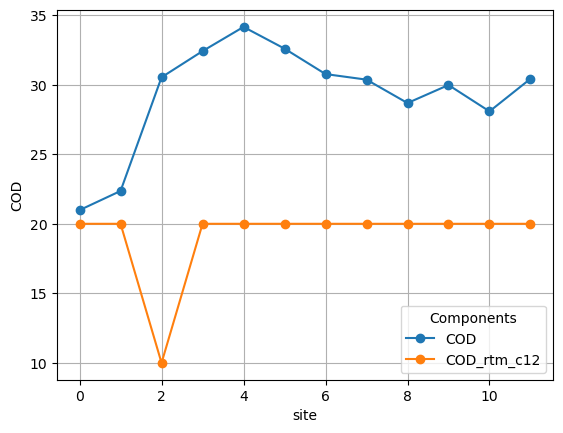

In [21]:
sat[['COD','COD_rtm_c12']].plot(style='o-')
plt.xlabel('site')  # Set x-axis label to COD
plt.ylabel('COD')  # Set y-axis label to Radiance
plt.grid(True)
plt.legend(title='Components')
plt.show()

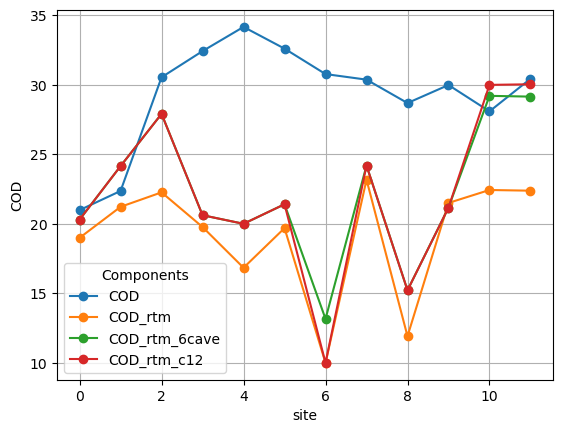

In [170]:
sat[['COD','COD_rtm','COD_rtm_6cave','COD_rtm_c12']].plot(style='o-')
plt.xlabel('site')  # Set x-axis label to COD
plt.ylabel('COD')  # Set y-axis label to Radiance
plt.grid(True)
plt.legend(title='Components')
plt.show()

### gradient algorithm

In [ ]:
def compute_gradient_simple(Rc_rtm_df, COD_list, Rc_real, RMSE_df, RMSE):
    """
    Linear fitting of COD, based on two nearest neighbors of Rc_real.
    """

    sorted_indices = np.argsort(RMSE_df['C02'].values) # ascendent order
    nearest_indices = sorted_indices[:2]
    # Sort nearest indices to ensure consistent order
    # nearest_indices.sort()
    Rc1, Rc2 = Rc_rtm_df.iloc[nearest_indices[0]], Rc_rtm_df.iloc[nearest_indices[1]]
    COD1, COD2 = COD_list[nearest_indices[0]], COD_list[nearest_indices[1]]
    # Compute the gradient using the two nearest points
    gradient = (Rc2 - Rc1)/(COD2 - COD1)
    # Calculate the COD at Rc_real using the linear approximation
    if RMSE < 5:
        learningrate = RMSE
        COD = COD1 + learningrate * gradient/abs(gradient)
        print(COD['C02'])
    else:
        COD = COD1 + (Rc_real - Rc1) / gradient

    # Debug logging
    #print(f"Debug: Gradient:\n {gradient}, COD_estimate:\n {COD}")

    COD_guess = round(float(COD['C02']), 2)
    if COD_guess <= 0:
        print("COD must be greater than 0, but got {}.".format(COD_guess))
    return COD_guess, COD

In [36]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

def compute_cod_regression(Rc_rtm_df, COD_list, Rc_real, component='C02'):
    # Convert COD_list and Rc_rtm_df for linear regression
    COD_array = np.array(COD_list).reshape(-1, 1)
    
    # Error values for the desired component
    error_array = Rc_rtm_df[component].values - Rc_real[1]
    
    # Initialize and fit the linear regression model
    model = LinearRegression()
    model.fit(COD_array, error_array)
    
    # Calculate the updated COD estimation based on predicted zero error point
    # error = COD * slope + intercept -> COD = (0 - intercept) / slope
    slope = model.coef_[0]
    intercept = model.intercept_

    COD_guess = -intercept / slope

    # Debug statement
    #print(f"Debug: Linear Regression on {component}: Slope = {slope}, Intercept = {intercept}, New COD_guess = {COD_guess}")

    return round(float(COD_guess), 2)

# Example usage:

# Assuming Rc_rtm_df, COD_list, and Rc_real are already defined in context
new_cod_guess = compute_cod_regression(Rc_rtm_df, COD_list, Rc_real, 'C02')
print(f"Updated COD Guess: {new_cod_guess}")

Updated COD Guess: 16.95


In [101]:
from scipy.interpolate import UnivariateSpline
import numpy as np
import pandas as pd

def compute_cod_spline_fit(Rc_rtm_df, COD_list, Rc_real, component='C02'):
    # Convert COD_list and Rc_rtm_df for spline interpolation
    COD_array = np.array(COD_list)
    
    # Error values for the desired component
    error_array = Rc_rtm_df[component].values - Rc_real[1]
    
    # Initialize and fit the univariate spline
    spline_model = UnivariateSpline(COD_array, error_array, s=1)
    
    # Calculate the updated COD estimation based on the predicted zero error point
    # We need to find the point where the error is zero using the spline
    root_candidates = spline_model.roots()

    # Check if there are valid roots, otherwise handle accordingly
    if len(root_candidates) > 0:
        COD_guess = root_candidates[0]
    else:
        COD_guess = np.nan  # or handle appropriately

    # Debug statement
    print(f"Debug: Spline roots for {component}: {root_candidates}, New COD_guess = {COD_guess}")

    return round(float(COD_guess), 2) if not np.isnan(COD_guess) else None

# Example usage:

# Assuming Rc_rtm_df, COD_list, and Rc_real are already defined in context
new_cod_guess = compute_cod_spline_fit(Rc_rtm_df, COD_list, Rc_real, 'C02')
print(f"Updated COD Guess: {new_cod_guess}")

ValueError: x must be increasing if s > 0

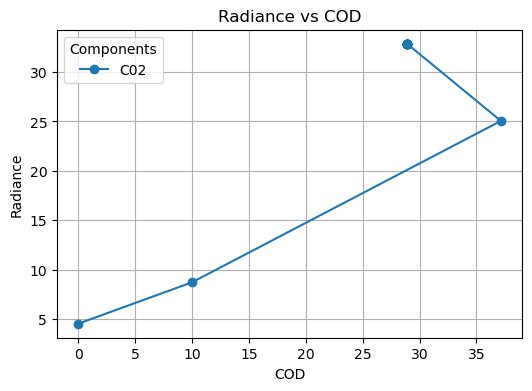

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming Rc_rtm_df, COD_list, and Rc_real are already defined

# Add the 'COD' column to the DataFrame
Rc_rtm_plot = (Rc_rtm_df.copy())
Rc_rtm_plot['COD'] = np.array(COD_list)

# Set the x-axis to use the 'COD' column explicitly
ax = Rc_rtm_plot[['C02','COD']].plot(x='COD', style='-o', figsize=(6, 4), title='Radiance vs COD')  
# 'o-' indicates circles for markers and lines for connection
#ax.axhline(Rc_real[1], color='red', linestyle='--', label='Reference Line')
plt.xlabel('COD')  # Set x-axis label to COD
plt.ylabel('Radiance')  # Set y-axis label to Radiance
plt.grid(True)
plt.legend(title='Components')
plt.show()

# Analysis :Given Zenith, COD impact on per solid angle Rad 

In [52]:
Sun_Zen, local_zen, rela_azi, COD_guess, T_a, RH, channels

(42.46119259192847,
 48.3569356275348,
 7.802676189331805,
 22.38,
 299.65,
 58.0,
 ['C01', 'C02', 'C03', 'C04', 'C05', 'C06'])

In [ ]:
Sun_Zen = np.array([0,15,30,45,60])
COD = np.arange(0,50,5.0)
Rad = []
for theta in Sun_Zen:
    for COD_guess in COD:
        Rc_rtm = nearealtime_RTM(theta, local_zen, rela_azi, COD_guess, T_a, RH, channels, file_dir=data_dir)
        Rad.append(Rc_rtm['C02'].values)
    plt.plot(COD,Rad,label=f"{theta}")
plt.legend(title='Zenith')
plt.show()

File uwxyzr_COD=0.0_th0=0_Ta=299.0_RH=60.0.npy not found. Running RTM...
Start MonteCarlo once.
CoeffM,nu= 2505
CPU time: 8.04041314125061
File uwxyzr_COD=5.0_th0=0_Ta=299.0_RH=60.0.npy not found. Running RTM...
Start MonteCarlo once.
CoeffM,nu= 2505
CPU time: 9.091320991516113
File uwxyzr_COD=10.0_th0=0_Ta=299.0_RH=60.0.npy not found. Running RTM...
Start MonteCarlo once.
CoeffM,nu= 2505
CPU time: 8.811449766159058
File uwxyzr_COD=15.0_th0=0_Ta=299.0_RH=60.0.npy not found. Running RTM...
Start MonteCarlo once.
CoeffM,nu= 2505
CPU time: 10.14420771598816
File uwxyzr_COD=20.0_th0=0_Ta=299.0_RH=60.0.npy not found. Running RTM...
Start MonteCarlo once.
CoeffM,nu= 2505
CPU time: 11.396042108535767
File uwxyzr_COD=25.0_th0=0_Ta=299.0_RH=60.0.npy not found. Running RTM...
Start MonteCarlo once.
CoeffM,nu= 2505
CPU time: 12.996469259262085
File uwxyzr_COD=30.0_th0=0_Ta=299.0_RH=60.0.npy not found. Running RTM...
Start MonteCarlo once.
CoeffM,nu= 2505
CPU time: 13.84858226776123
File uwxyzr_CO

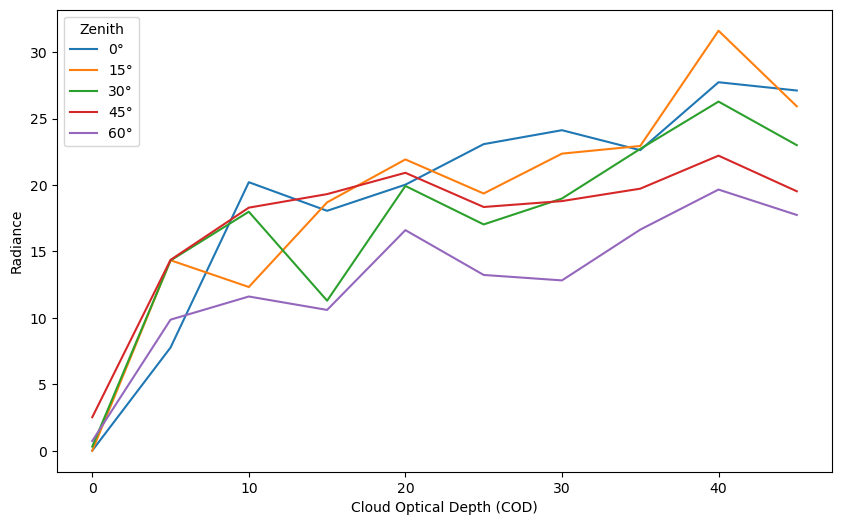

In [64]:
Sun_Zen = np.array([0,15,30,45,60])
COD = np.arange(0,50,5.0)
plt.figure(figsize=(10, 6))

for theta in Sun_Zen:
    Rad = []
    for COD_guess in COD:
        Rc_rtm = nearealtime_RTM(theta, local_zen, rela_azi, COD_guess, T_a, RH, channels, file_dir=data_dir)
        Rad.append(Rc_rtm['C02'].values)
    plt.plot(COD, Rad, label=f"{theta}°")
plt.legend(title='Zenith')
plt.xlabel('Cloud Optical Depth (COD)')
plt.ylabel('Radiance')
plt.show()

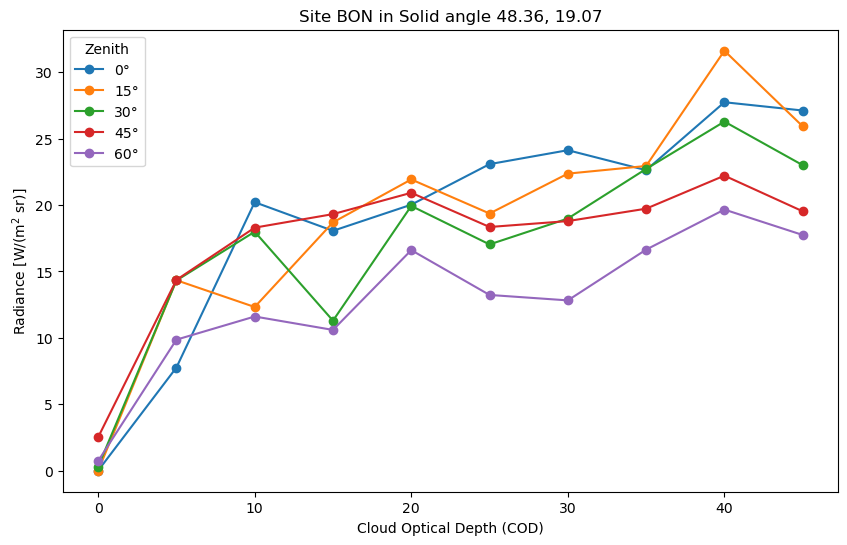

In [72]:
Sun_Zen = np.array([0,15,30,45,60])
COD = np.arange(0,50,5.0)
plt.figure(figsize=(10, 6))

for theta in Sun_Zen:
    Rad = []
    for COD_guess in COD:
        Rc_rtm = nearealtime_RTM(theta, local_zen, rela_azi, COD_guess, T_a, RH, channels, file_dir=data_dir)
        Rad.append(Rc_rtm['C02'].values)
    plt.plot(COD, Rad, 'o-', label=f"{theta}°")
plt.legend(title='Zenith')
plt.xlabel('Cloud Optical Depth (COD)')
plt.ylabel(r'Radiance [W/(m$^2$ sr)]')
plt.title(f'Site BON in Solid angle {np.round(local_zen,2)}, {np.round(rela_azi,2)}')
plt.show()

# nu grid 

In [41]:
channel = "02"
channels = ['C{:02d}'.format(c) for c in range(1, 6 + 1)]
nu = np.arange(2500, 35000,3)
print('full',nu,nu.shape)
print('channels',goes_calinu(nu, channels, file_dir, dnu=3),goes_calinu(nu, channels, file_dir, dnu=3).shape)

file_dir = './GOES_data/'
# channel
nu_channel = goes_calinu(nu, [channel], file_dir, dnu=3)
print(nu_channel)

full [ 2500  2503  2506 ... 34993 34996 34999] (10834,)
channels [ 4372  4375  4378 ... 22606 22609 22612] (2505,)
[14293 14296 14299 ... 17458 17461 17464]


In [46]:
np.nonzero(np.isin(nu,goes_calinu(nu, channels, file_dir, dnu=3)))[0]

array([ 624,  625,  626, ..., 6702, 6703, 6704])

In [11]:
bandmode = 'full' #'full' 

if bandmode == 'full':
    # LBL
    nu_input = nu
else:
    # 6 channels
    nu_input = goes_calinu(nu, channels, file_dir, dnu=3)

#nu_channel in nu_LBL 
# Extract indices in nu_input where nu_channel appears in nu_input
nu_idx = np.nonzero(np.isin(nu_input,nu_channel))[0]

In [12]:
ch = nu_input[nu_idx]
ch

array([14293, 14296, 14299, ..., 17458, 17461, 17464])

In [13]:
lbl = nu_input[nu_idx]
lbl

array([14293, 14296, 14299, ..., 17458, 17461, 17464])

In [15]:
nu_input.shape

(10834,)

In [16]:
lbl[lbl != nu_channel]

array([], dtype=int64)